Definição do problema

In [1592]:
"""
Os orçamentos públicos dos entes federativos contém a projeção de receitas do ano respectivo, e a partir delas são planejadas as despesas públicas desse mesmo ano.
É sempre um desafio para os gestores públicos prever os valores realizáveis dessas receitas, dadas as variáveis que afetam a arrecadação.
Este trabalho pretende apresentar um modelo supervisionado que auxilie a projeção das receitas tributárias para os anos seguintes, baseado no histórico de arrecadação dos tributos, por estado.
Nossa hipótese inicial é de que perfil do crescimento ou redução de cada tributo ao passar dos anos possa indicar os efeitos na arrecadação dos anos seguintes.
Para isso, será utilizado um dataset extraído do portal de dados abertos do governo federal. Partimos do pressuposto de que as informações nele contidas, foram aprovados pelos tribunais de contas e que são os dados oficiais de cada estado.
Os dados do dataset estão atualizados até março de 2023, mas dada a proposta de projeção de receitas para o ano, serão considerados apenas os dados até dezembro de 2022. Em virtude da pandemia e os seus efeitos econômicos, o comportamento dos dados de 2020 e 2021 farão parte do teste, porém poderão serem avaliados em separado.
"""

'\nOs orçamentos públicos dos entes federativos contém a projeção de receitas do ano respectivo, e a partir delas são planejadas as despesas públicas desse mesmo ano.\nÉ sempre um desafio para os gestores públicos prever os valores realizáveis dessas receitas, dadas as variáveis que afetam a arrecadação.\nEste trabalho pretende apresentar um modelo supervisionado que auxilie a projeção das receitas tributárias para os anos seguintes, baseado no histórico de arrecadação dos tributos, por estado.\nNossa hipótese inicial é de que perfil do crescimento ou redução de cada tributo ao passar dos anos possa indicar os efeitos na arrecadação dos anos seguintes.\nPara isso, será utilizado um dataset extraído do portal de dados abertos do governo federal. Partimos do pressuposto de que as informações nele contidas, foram aprovados pelos tribunais de contas e que são os dados oficiais de cada estado.\nOs dados do dataset estão atualizados até março de 2023, mas dada a proposta de projeção de recei

In [1593]:
#Importando bibliotecas que serão utilizadas no trabalho
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import missingno as ms
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder 

Carregando dataset

In [1594]:
#Definindo path do dataset
url_dados: str = 'https://raw.githubusercontent.com/leonardevop/mvp_1/main/arrecadacao-estado%20(1).csv'

#Carregando dataset. Utilizado encoding cp1252 após inconsistências com o padrão utf-8.
arrecadacao = pd.read_csv(url_dados, delimiter=';', encoding='cp1252')

Análise de Dados

In [1595]:
#Avaliando o conjunto completo do dataframe
arrecadacao

,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
0,2000,Janeiro,AC,231,0,292096,0,0,167,1558,...,NaN,NaN,NaN,NaN,20911,NaN,NaN,NaN,NaN,NaN
1,2000,Janeiro,AL,475088,33873,1329338,812470,0,141735,3676847,...,NaN,NaN,NaN,NaN,127189,NaN,NaN,NaN,NaN,NaN
2,2000,Janeiro,AM,11679405,0,1507146,1791471,27796,4414483,1800346,...,NaN,NaN,NaN,NaN,187988,NaN,NaN,NaN,NaN,NaN
3,2000,Janeiro,AP,24267,0,424862,1419,321,22333,12165,...,NaN,NaN,NaN,NaN,10769,NaN,NaN,NaN,NaN,NaN
4,2000,Janeiro,BA,10476457,13,5542123,11533707,0,7496476,23743858,...,NaN,NaN,NaN,NaN,536498,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7528,2023,Março,RS,15836217,0,0,0,0,2420866,23524606,...,NaN,NaN,NaN,NaN,56294066,NaN,6.874600e+09,NaN,NaN,1.065146e+09
7529,2023,Março,SC,1002120548,858532,0,897532412,3011745881,3881102956,3720682797,...,NaN,NaN,NaN,NaN,8971306055,NaN,2.420498e+09,NaN,NaN,2.907057e+09
7530,2023,Março,SE,1792437623,-1309421,231803776,451808802,1839273499,6451088764,1033460741,...,NaN,NaN,NaN,NaN,1480417865,NaN,1.779441e+10,NaN,NaN,2.574332e+08
7531,2023,Março,SP,379440024,214698413,37450835,203994968,0,11139877,657689162,...,NaN,NaN,NaN,NaN,380583903,NaN,2.347739e+09,NaN,NaN,3.542186e+09


In [1596]:
#Verificando os tipos de dados de cada coluna do dataframe
arrecadacao.dtypes
#Dado que o dataset está voltado para a apresentação de valores de cada fonte de arrecadação, percebe-se algo estranho com a maioria das colunas apresentadas como objects.

Ano                                                               int64
Mês                                                              object
UF                                                               object
IMPOSTO SOBRE IMPORTAÇÃO                                          int64
IMPOSTO SOBRE EXPORTAÇÃO                                          int64
IPI - FUMO                                                        int64
IPI - BEBIDAS                                                     int64
IPI - AUTOMÓVEIS                                                  int64
IPI - VINCULADO À IMPORTACAO                                      int64
IPI - OUTROS                                                      int64
IRPF                                                              int64
IRPJ - ENTIDADES FINANCEIRAS                                      int64
IRPJ - DEMAIS EMPRESAS                                            int64
IRRF - RENDIMENTOS DO TRABALHO                                  

In [1597]:
#Consultando os primeiros registros do dataframe
arrecadacao.head()
#Identificados alguns dados faltantes com o registro "NaN".
#Identificado que o dataset possui 45 atributos.

,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
0,2000,Janeiro,AC,231,0,292096,0,0,167,1558,...,NaN,NaN,NaN,NaN,20911,NaN,NaN,NaN,NaN,NaN
1,2000,Janeiro,AL,475088,33873,1329338,812470,0,141735,3676847,...,NaN,NaN,NaN,NaN,127189,NaN,NaN,NaN,NaN,NaN
2,2000,Janeiro,AM,11679405,0,1507146,1791471,27796,4414483,1800346,...,NaN,NaN,NaN,NaN,187988,NaN,NaN,NaN,NaN,NaN
3,2000,Janeiro,AP,24267,0,424862,1419,321,22333,12165,...,NaN,NaN,NaN,NaN,10769,NaN,NaN,NaN,NaN,NaN
4,2000,Janeiro,BA,10476457,13,5542123,11533707,0,7496476,23743858,...,NaN,NaN,NaN,NaN,536498,NaN,NaN,NaN,NaN,NaN


In [1598]:
#Consultando os últimos registros no dataframe
arrecadacao.tail()
#Identificado que os últimos registros indicam que os dados foram atualizados até Março de 2023.
#Verificado que há 7533 linhas no dataframe.

,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
7528,2023,Março,RS,15836217,0,0,0,0,2420866,23524606,...,NaN,NaN,NaN,NaN,56294066,NaN,6.874600e+09,NaN,NaN,1.065146e+09
7529,2023,Março,SC,1002120548,858532,0,897532412,3011745881,3881102956,3720682797,...,NaN,NaN,NaN,NaN,8971306055,NaN,2.420498e+09,NaN,NaN,2.907057e+09
7530,2023,Março,SE,1792437623,-1309421,231803776,451808802,1839273499,6451088764,1033460741,...,NaN,NaN,NaN,NaN,1480417865,NaN,1.779441e+10,NaN,NaN,2.574332e+08
7531,2023,Março,SP,379440024,214698413,37450835,203994968,0,11139877,657689162,...,NaN,NaN,NaN,NaN,380583903,NaN,2.347739e+09,NaN,NaN,3.542186e+09
7532,2023,Março,TO,24659064,0,0,32331297,0,168231541,140113866,...,NaN,NaN,NaN,NaN,23348497,NaN,1.952184e+09,NaN,NaN,2.955795e+09


In [1599]:
#Consultando as 45 colunas do dataframe
arrecadacao.columns
#Identificado que há segregações do mesmo imposto em diferentes categorias.
#Identificadas colunas que podem conter subtotais das colunas segregadas, ou mudanças de critérios de totalização dos valores ao longo do tempo.

Index(['Ano', 'Mês', 'UF', 'IMPOSTO SOBRE IMPORTAÇÃO',
       'IMPOSTO SOBRE EXPORTAÇÃO', 'IPI - FUMO', 'IPI - BEBIDAS',
       'IPI - AUTOMÓVEIS', 'IPI - VINCULADO À IMPORTACAO', 'IPI - OUTROS',
       'IRPF', 'IRPJ - ENTIDADES FINANCEIRAS', 'IRPJ - DEMAIS EMPRESAS',
       'IRRF - RENDIMENTOS DO TRABALHO', 'IRRF - RENDIMENTOS DO CAPITAL',
       'IRRF - REMESSAS P/ EXTERIOR', 'IRRF - OUTROS RENDIMENTOS',
       'IMPOSTO S/ OPERAÇÕES FINANCEIRAS', 'IMPOSTO TERRITORIAL RURAL',
       'IMPOSTO PROVIS.S/ MOVIMENT. FINANC. - IPMF', 'CPMF', 'COFINS',
       'COFINS - FINANCEIRAS', 'COFINS - DEMAIS',
       'CONTRIBUIÇÃO PARA O PIS/PASEP',
       'CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS',
       'CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS', 'CSLL', 'CSLL - FINANCEIRAS',
       'CSLL - DEMAIS', 'CIDE-COMBUSTÍVEIS (parc. não dedutível)',
       'CIDE-COMBUSTÍVEIS', 'CONTRIBUIÇÃO PLANO SEG. SOC. SERVIDORES',
       'CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público',
       'CONTRIB

In [1600]:
#Confirmando dimensões do dataframe
arrecadacao.shape
#Volume de dados anteriormente identificados confirmados

(7533, 45)

In [1601]:
#Verificando o total de registros por cada coluna do dataframe
arrecadacao.count()
#Identificado que apenas algumas colunas possuem registros em todas as linhas, sugerindo eventuais erros, alterações de critérios de totalização, ou extinção de tributos. 

Ano                                                             7533
Mês                                                             7533
UF                                                              7533
IMPOSTO SOBRE IMPORTAÇÃO                                        7533
IMPOSTO SOBRE EXPORTAÇÃO                                        7533
IPI - FUMO                                                      7533
IPI - BEBIDAS                                                   7533
IPI - AUTOMÓVEIS                                                7533
IPI - VINCULADO À IMPORTACAO                                    7533
IPI - OUTROS                                                    7533
IRPF                                                            7533
IRPJ - ENTIDADES FINANCEIRAS                                    7533
IRPJ - DEMAIS EMPRESAS                                          7533
IRRF - RENDIMENTOS DO TRABALHO                                  7533
IRRF - RENDIMENTOS DO CAPITAL     

In [1602]:
#Obtendo um resumo das informações do dataframe
arrecadacao.describe()
#Verificado que há valores mínimos negativos em algumas colunas. Valores podem significar valores de créditos ao contribuinte concedidos maior do que valor recolhido, ou preenchimentos incorretos.

,Ano,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,IRPF,IRPJ - ENTIDADES FINANCEIRAS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
count,7533.000000,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,...,3.240000e+02,3.240000e+02,2.700000e+02,3.780000e+02,7.533000e+03,2.160000e+03,1.971000e+03,1.431000e+03,1.431000e+03,4.077000e+03
mean,2011.129032,1.034112e+09,3.202691e+06,1.718195e+08,4.160473e+08,3.366193e+08,8.444121e+08,8.956928e+08,1.369203e+09,5.062470e+08,...,2.163363e+06,8.472560e+06,1.295935e+07,9.749743e+06,9.241200e+08,5.956634e+08,4.039714e+09,2.350958e+09,1.994049e+09,2.617280e+09
std,6.713017,2.091124e+09,2.543243e+07,8.290416e+08,1.039016e+09,1.148168e+09,1.925163e+09,1.947720e+09,2.091944e+09,1.359094e+09,...,3.904852e+06,1.657378e+07,3.508999e+07,1.876911e+07,1.840472e+09,1.495395e+09,3.195786e+09,2.657790e+09,2.428874e+09,2.700646e+09
min,2000.000000,-1.792566e+07,-9.155959e+07,-4.329186e+08,-1.079723e+07,-1.454896e+08,0.000000e+00,-3.485777e+08,1.228300e+04,-8.099953e+08,...,-1.797889e+06,1.360000e+05,9.309000e+03,1.161950e+05,-1.991267e+10,-1.974837e+07,3.446879e+07,2.256750e+07,1.270067e+06,-5.810897e+09
25%,2005.000000,1.357881e+06,0.000000e+00,0.000000e+00,2.124144e+06,0.000000e+00,4.664470e+05,3.000652e+06,8.080265e+06,3.207400e+04,...,2.972922e+05,1.179268e+06,5.177198e+05,1.236024e+06,1.964925e+06,2.468620e+06,1.812181e+09,3.749883e+08,4.787868e+07,3.833357e+08
50%,2011.000000,3.249109e+07,3.074000e+03,6.235990e+05,1.801698e+07,6.069000e+03,2.077800e+07,9.389117e+07,3.090043e+08,3.252555e+06,...,7.620455e+05,2.561976e+06,2.529214e+06,2.937894e+06,1.032554e+08,2.374454e+07,3.114104e+09,1.531095e+09,1.277967e+09,1.765880e+09
75%,2017.000000,9.299352e+08,2.303110e+05,5.832567e+06,3.025808e+08,6.402158e+06,3.649608e+08,6.949584e+08,1.907351e+09,1.527524e+08,...,2.336568e+06,6.589126e+06,8.767503e+06,8.698714e+06,9.923987e+08,3.478209e+08,5.554899e+09,3.175925e+09,2.977983e+09,3.929632e+09
max,2023.000000,9.978470e+09,1.557215e+09,9.904761e+09,9.945420e+09,9.967381e+09,9.990833e+09,9.996958e+09,9.999580e+09,9.940508e+09,...,2.458967e+07,8.532303e+07,2.138863e+08,1.032222e+08,2.289754e+10,9.938066e+09,2.778681e+10,1.949341e+10,9.889055e+09,2.247643e+10


In [1603]:
#Alterando a ordem da distribuição por UF, Ano e Mês
arrecadacao.sort_values(by=['UF', 'Ano', 'Mês'])
#Identificado que o atributo mês, por ser categórico, atrapalha a ordenação


,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,REFIS,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
81,2000,Abril,AC,69,0,281844,0,0,53,15332,...,NaN,NaN,NaN,NaN,16011,NaN,NaN,NaN,NaN,NaN
189,2000,Agosto,AC,514,0,278217,0,0,0,12191,...,NaN,NaN,NaN,NaN,53755,NaN,NaN,NaN,NaN,NaN
297,2000,Dezembro,AC,784,0,313571,0,0,111,7409,...,NaN,NaN,NaN,NaN,38439,NaN,NaN,NaN,NaN,NaN
27,2000,Fevereiro,AC,441,0,255361,0,0,0,11437,...,NaN,NaN,NaN,NaN,21142,NaN,NaN,NaN,NaN,NaN
0,2000,Janeiro,AC,231,0,292096,0,0,167,1558,...,NaN,NaN,NaN,NaN,20911,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7397,2022,Outubro,TO,35,49347,0,913183,0,0,188935471,...,NaN,NaN,NaN,NaN,397732912,NaN,1.930621e+08,NaN,NaN,1.337500e+09
7370,2022,Setembro,TO,84315,2732,0,18089442,0,48994066,236816107,...,NaN,NaN,NaN,NaN,544496168,NaN,1.955863e+09,NaN,NaN,3.669632e+09
7505,2023,Fevereiro,TO,329789178,-4,0,36343944,686202,108584577,97787379,...,NaN,NaN,NaN,NaN,5169123,NaN,1.837454e+09,NaN,NaN,2.698647e+09
7478,2023,Janeiro,TO,317412404,-44,0,37682617,0,162485421,108892604,...,NaN,NaN,NaN,NaN,207209162,NaN,2.040047e+09,NaN,NaN,2.675652e+09


In [1604]:
#Verificando segregações das coluinas de IPI para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:, ['IPI - FUMO', 'IPI - BEBIDAS', 'IPI - AUTOMÓVEIS', 'IPI - VINCULADO À IMPORTACAO', 'IPI - OUTROS']]
#Não identificadas subtotalizações, mas aparentemente, informações inconsistentes, tais como arrecadação zerada de IPI para Fumo e Bebidas, que dificilmente terão isenção de IPI.


,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS
0,292096,0,0,167,1558
1,1329338,812470,0,141735,3676847
2,1507146,1791471,27796,4414483,1800346
3,424862,1419,321,22333,12165
4,5542123,11533707,0,7496476,23743858
...,...,...,...,...,...
7528,0,0,0,2420866,23524606
7529,0,897532412,3011745881,3881102956,3720682797
7530,231803776,451808802,1839273499,6451088764,1033460741
7531,37450835,203994968,0,11139877,657689162


In [1605]:
#Verificando segregações das colunas de COFINS para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:,['Ano', 'Mês', 'UF','COFINS', 'COFINS - FINANCEIRAS', 'COFINS - DEMAIS']]
#Identificada que a distribuição inicial não contém números para as segregações, e as finais, contém. Provavelmente, houve uma mudança de critério de arrecadação em um determinado período, onde sos códigos para recolhimento da COFINS podem ter sido segregados.

,Ano,Mês,UF,COFINS,COFINS - FINANCEIRAS,COFINS - DEMAIS
0,2000,Janeiro,AC,1770475.0,NaN,NaN
1,2000,Janeiro,AL,7493570.0,NaN,NaN
2,2000,Janeiro,AM,44000981.0,NaN,NaN
3,2000,Janeiro,AP,1682102.0,NaN,NaN
4,2000,Janeiro,BA,81027229.0,NaN,NaN
...,...,...,...,...,...,...
7528,2023,Março,RS,NaN,8.803350e+05,1.617155e+09
7529,2023,Março,SC,NaN,2.588785e+08,2.008501e+09
7530,2023,Março,SE,NaN,1.295632e+09,9.767005e+09
7531,2023,Março,SP,NaN,2.195049e+08,6.062310e+09


In [1606]:
#Verificando segregações das colunas de Receita Previdenciária para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:,['Ano', 'Mês', 'UF','RECEITA PREVIDENCIÁRIA', 'RECEITA PREVIDENCIÁRIA - PRÓPRIA', 'RECEITA PREVIDENCIÁRIA - DEMAIS', 'ADMINISTRADAS POR OUTROS ÓRGÃOS']]
#Identificado que há ausência de informações nos primeiros períodos e para o final não é possível identificar o motivo da segregação.

,Ano,Mês,UF,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS
0,2000,Janeiro,AC,NaN,NaN,NaN,NaN
1,2000,Janeiro,AL,NaN,NaN,NaN,NaN
2,2000,Janeiro,AM,NaN,NaN,NaN,NaN
3,2000,Janeiro,AP,NaN,NaN,NaN,NaN
4,2000,Janeiro,BA,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7528,2023,Março,RS,6.874600e+09,NaN,NaN,1.065146e+09
7529,2023,Março,SC,2.420498e+09,NaN,NaN,2.907057e+09
7530,2023,Março,SE,1.779441e+10,NaN,NaN,2.574332e+08
7531,2023,Março,SP,2.347739e+09,NaN,NaN,3.542186e+09


In [1607]:
#Verificando segregações das colunas de Imposto de renda para checar se há subtotalizações, analisando todas as linhas.
arrecadacao.loc[:,['Ano', 'Mês', 'UF','CSLL', 'CSLL - FINANCEIRAS', 'CSLL - DEMAIS']]
#Identificada que a distribuição inicial não contém números para as segregações, e as finais, contém. Provavelmente, houve uma mudança de critério de arrecadação em um determinado período, onde sos códigos para recolhimento da CSLL podem ter sido segregados.

,Ano,Mês,UF,CSLL,CSLL - FINANCEIRAS,CSLL - DEMAIS
0,2000,Janeiro,AC,392830.0,NaN,NaN
1,2000,Janeiro,AL,1775834.0,NaN,NaN
2,2000,Janeiro,AM,7652859.0,NaN,NaN
3,2000,Janeiro,AP,346964.0,NaN,NaN
4,2000,Janeiro,BA,15699282.0,NaN,NaN
...,...,...,...,...,...,...
7528,2023,Março,RS,NaN,7.853500e+04,7.270771e+08
7529,2023,Março,SC,NaN,3.442156e+08,2.777630e+09
7530,2023,Março,SE,NaN,1.886354e+09,2.964038e+09
7531,2023,Março,SP,NaN,2.434271e+08,2.701283e+09


Primeiros Tratamentos

In [1608]:
' Dada a inconsistência dos dados, será necessário realizar o tratamento antecipado de alguns dados, para viablizar uma análise mais consistente dos indicadores. '

' Dada a inconsistência dos dados, será necessário realizar o tratamento antecipado de alguns dados, para viablizar uma análise mais consistente dos indicadores. '

<AxesSubplot: >

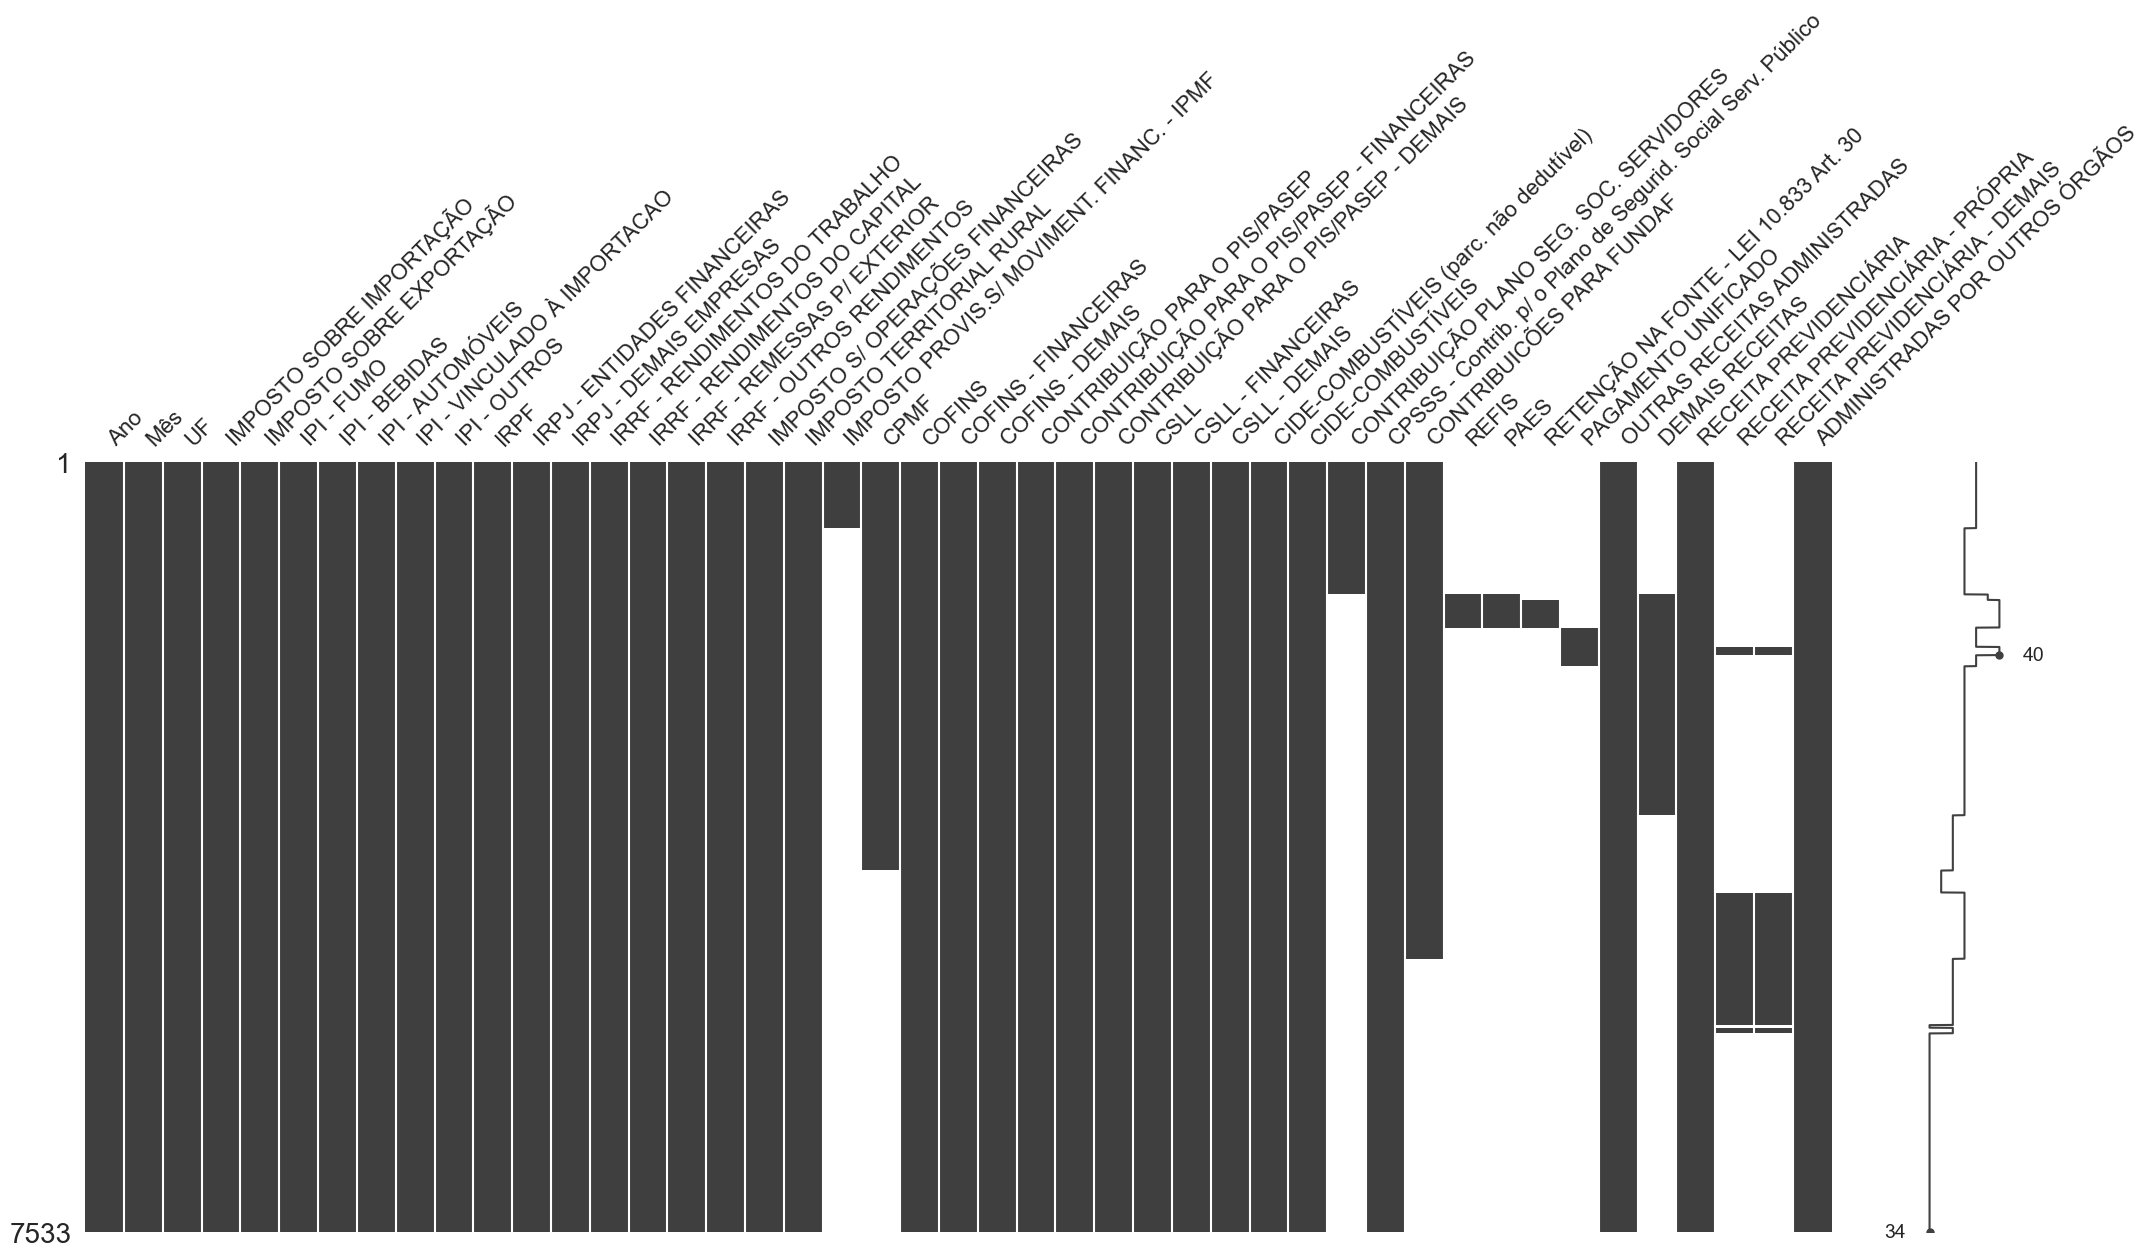

In [1609]:
#Preenchendo missings com valor 0 nas colunas que serão agregadas
arrecadacao['CSLL'] = arrecadacao['CSLL'].fillna(0)
arrecadacao['CSLL - DEMAIS'] = arrecadacao['CSLL - DEMAIS'].fillna(0)
arrecadacao['CSLL - FINANCEIRAS'] = arrecadacao['CSLL - FINANCEIRAS'].fillna(0)
arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP'] = arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP'].fillna(0)
arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS'] = arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS'].fillna(0) 
arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS'] = arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS'].fillna(0)
arrecadacao['COFINS'] = arrecadacao['COFINS'].fillna(0) 
arrecadacao['COFINS - FINANCEIRAS'] = arrecadacao['COFINS - FINANCEIRAS'].fillna(0)
arrecadacao['COFINS - DEMAIS'] = arrecadacao['COFINS - DEMAIS'].fillna(0)
arrecadacao['CIDE-COMBUSTÍVEIS'] = arrecadacao['CIDE-COMBUSTÍVEIS'].fillna(0)
arrecadacao['CIDE-COMBUSTÍVEIS (parc. não dedutível)'] = arrecadacao['CIDE-COMBUSTÍVEIS (parc. não dedutível)'].fillna(0)

#Preenchendo missings com a mediana para as colunas que iniciaram arrecadação em período posterior as demais receitas iniciais e ainda permanecem sendo arrecadadas
arrecadacao['CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público'].fillna(arrecadacao['CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público'].median(), inplace=True)
arrecadacao['RECEITA PREVIDENCIÁRIA'].fillna(arrecadacao['RECEITA PREVIDENCIÁRIA'].median(), inplace=True)
arrecadacao['ADMINISTRADAS POR OUTROS ÓRGÃOS'].fillna(arrecadacao['ADMINISTRADAS POR OUTROS ÓRGÃOS'].median(), inplace=True)

#Verificando matriz de valores nulos do dataset
ms.matrix(arrecadacao)


In [1610]:
#Convertendo dados do mês para formato numérico.
conversao_mes: dict = {'Janeiro': 1, 'Fevereiro': 2, 'Março': 3, 'Abril': 4, 'Maio': 5, 'Junho': 6, 'Julho': 7, 'Agosto': 8, 'Setembro': 9, 'Outubro': 10, 'Novembro': 11, 'Dezembro': 12}
arrecadacao['DATA'] = range(0, 7533)
for i,j in enumerate(arrecadacao['Ano']):
    arrecadacao['Mês'][i] = conversao_mes[arrecadacao['Mês'][i]]
    arrecadacao['DATA'][i] = dt.strptime('1' + '/' + str(arrecadacao['Mês'][i]) + '/' + str(j), '%d/%m/%Y').date()
arrecadacao['Mês'] = pd.to_numeric(arrecadacao['Mês'])
#Verificando alteração do tipo de dado
arrecadacao.dtypes


C:\Users\us6x\AppData\Local\Temp\ipykernel_15040\4200012327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrecadacao['Mês'][i] = conversao_mes[arrecadacao['Mês'][i]]
C:\Users\us6x\AppData\Local\Temp\ipykernel_15040\4200012327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arrecadacao['DATA'][i] = dt.strptime('1' + '/' + str(arrecadacao['Mês'][i]) + '/' + str(j), '%d/%m/%Y').date()


KeyboardInterrupt: 

In [ ]:
#Agregando colunas

#Foi identificado que as colunas seguintes foram segregadas ao longo do tempo em função de mudançãs de critérios de arrecadação. Dessa forma, para garantir a uniformidade da análise, as mesmas foram agrupadas novamente.
arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP'] = arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP'] + arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS'] + arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS']
arrecadacao['IPI'] = arrecadacao['IPI - FUMO'] + arrecadacao['IPI - BEBIDAS'] + arrecadacao['IPI - AUTOMÓVEIS'] + arrecadacao['IPI - VINCULADO À IMPORTACAO'] + arrecadacao['IPI - OUTROS']
arrecadacao['IRPJ'] = arrecadacao['IRPJ - ENTIDADES FINANCEIRAS'] +  arrecadacao['IRPJ - DEMAIS EMPRESAS']
arrecadacao['IRRF'] = arrecadacao['IRRF - RENDIMENTOS DO TRABALHO'] + arrecadacao['IRRF - RENDIMENTOS DO CAPITAL'] + arrecadacao['IRRF - REMESSAS P/ EXTERIOR'] + arrecadacao['IRRF - OUTROS RENDIMENTOS']
arrecadacao['CSLL'] = arrecadacao['CSLL'] + arrecadacao['CSLL - DEMAIS'] + arrecadacao['CSLL - FINANCEIRAS']
arrecadacao['COFINS'] = arrecadacao['COFINS - FINANCEIRAS'] + arrecadacao['COFINS'] + arrecadacao['COFINS - DEMAIS']
arrecadacao['CIDE-COMBUSTÍVEIS'] = arrecadacao['CIDE-COMBUSTÍVEIS'] + arrecadacao['CIDE-COMBUSTÍVEIS (parc. não dedutível)']

#Conferindo alteração dos tipos de dados
arrecadacao.isnull().sum()

Ano                                                                0
Mês                                                                0
UF                                                                 0
IMPOSTO SOBRE IMPORTAÇÃO                                           0
IMPOSTO SOBRE EXPORTAÇÃO                                           0
IPI - FUMO                                                         0
IPI - BEBIDAS                                                      0
IPI - AUTOMÓVEIS                                                   0
IPI - VINCULADO À IMPORTACAO                                       0
IPI - OUTROS                                                       0
IRPF                                                               0
IRPJ - ENTIDADES FINANCEIRAS                                       0
IRPJ - DEMAIS EMPRESAS                                             0
IRRF - RENDIMENTOS DO TRABALHO                                     0
IRRF - RENDIMENTOS DO CAPITAL     

<AxesSubplot: >

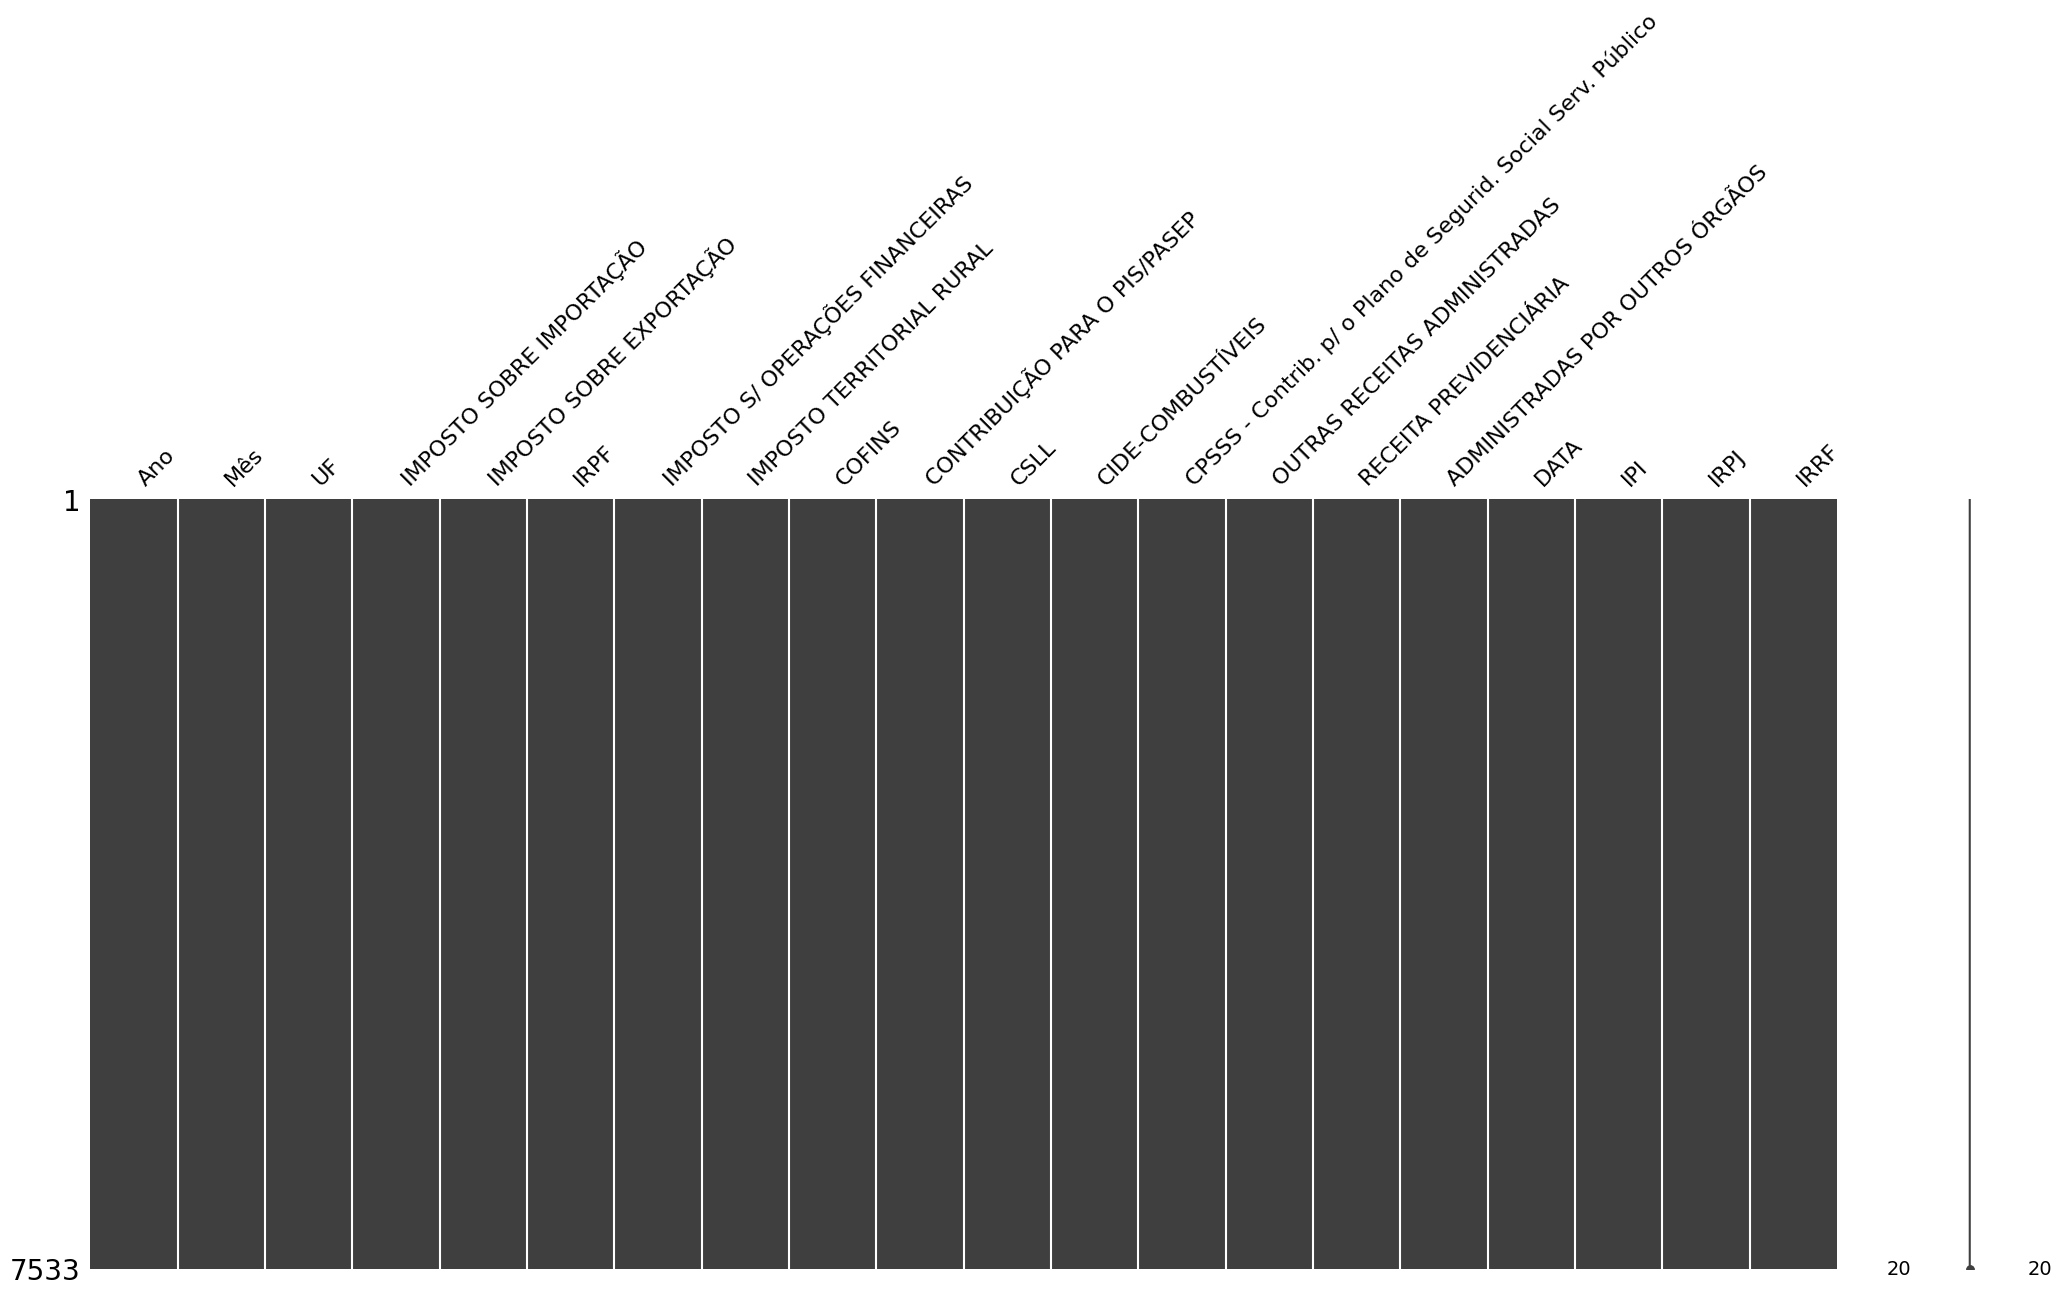

In [ ]:
#Eliminando colunas desnecessárias

#O conjunto das colunas não contribui para a o modelo que se pretende construir, dados que são colunas que foram agregadas, impostos extintos, critérios de arrecadação temporários etc.
arrecadacao = arrecadacao.drop(columns=['IMPOSTO PROVIS.S/ MOVIMENT. FINANC. - IPMF', 'CPMF', 'CONTRIBUIÇÃO PARA O PIS/PASEP - FINANCEIRAS', 'CONTRIBUIÇÃO PARA O PIS/PASEP - DEMAIS', 'IPI - FUMO', 'IPI - BEBIDAS', 'IPI - AUTOMÓVEIS', 'IPI - VINCULADO À IMPORTACAO', 'IPI - OUTROS', 'IRPJ - ENTIDADES FINANCEIRAS', 'IRPJ - DEMAIS EMPRESAS', 'IRRF - RENDIMENTOS DO TRABALHO', 'IRRF - RENDIMENTOS DO CAPITAL', 'IRRF - REMESSAS P/ EXTERIOR', 'IRRF - OUTROS RENDIMENTOS', 'CSLL - DEMAIS', 'CSLL - FINANCEIRAS', 'COFINS - FINANCEIRAS', 'COFINS - DEMAIS', 'CIDE-COMBUSTÍVEIS (parc. não dedutível)', 'CONTRIBUICÕES PARA FUNDAF', 'DEMAIS RECEITAS', 'RECEITA PREVIDENCIÁRIA - PRÓPRIA', 'RECEITA PREVIDENCIÁRIA - DEMAIS', 'PAGAMENTO UNIFICADO', 'REFIS', 'PAES', 'RETENÇÃO NA FONTE - LEI 10.833 Art. 30', 'CONTRIBUIÇÃO PLANO SEG. SOC. SERVIDORES'])

#Verificando novamente matriz de valores nulos do dataset
ms.matrix(arrecadacao)

Reanalisando dados após o primeiro tratamento

In [ ]:
#Verificando o média anual por Unidade Federativa dos valores arrecadados.
arrecadacao.groupby(['Ano', 'UF']).mean(numeric_only=True)

#Variação das médias demonstra a discrepância entre a arrecadação dos estados.

Mês  IMPOSTO SOBRE IMPORTAÇÃO  IMPOSTO SOBRE EXPORTAÇÃO  \
Ano  UF                                                            
2000 AC  6.5              8.135833e+02              1.083333e+00   
     AL  6.5              5.699383e+05              1.908550e+04   
     AM  6.5              1.367492e+07              5.891667e+01   
     AP  6.5              3.962717e+04              0.000000e+00   
     BA  6.5              1.486155e+07              9.242500e+02   
...      ...                       ...                       ...   
2023 RS  2.0              1.092364e+09              8.228733e+04   
     SC  2.0              6.540383e+09              7.827063e+05   
     SE  2.0              8.525544e+08             -4.445530e+05   
     SP  2.0              1.263729e+09              7.186953e+07   
     TO  2.0              2.239535e+08             -1.600000e+01   

                 IRPF  IMPOSTO S/ OPERAÇÕES FINANCEIRAS  \
Ano  UF                                                   
2000 AC  4.018123e+05                      1.524917e+03   
     AL  1.498026e+06                      1.230083e+04   
     AM  1.725184e+06                      1.118547e+06   
     AP  3.602833e+05                      1.682000e+03   
     BA  6.088068e+06                      2.373709e+06   
...               ...                               ...   
2023 RS  1.130762e+09                      1.093896e+09   
     SC  6.757695e+09                      6.226650e+09   
     SE  3.434387e+09                      1.401929e+09   
     SP  3.632546e+09                      2.421926e+09   
     TO  6.311650e+08                      4.871494e+07   

         IMPOSTO TERRITORIAL RURAL        COFINS  \
Ano  UF                                            
2000 AC               3.599075e+04  1.553726e+06   
     AL               4.456512e+05  8.391335e+06   
     AM               3.139158e+04  5.660133e+07   
     AP               1.838167e+04  1.525273e+06   
     BA               8.913393e+05  8.129811e+07   
...                            ...           ...   
2023 RS               1.136134e+08  2.772466e+09   
     SC               1.077362e+08  2.173994e+09   
     SE               2.508678e+08  8.403296e+09   
     SP               4.337960e+08  1.252138e+10   
     TO               1.434422e+08  4.285321e+09   

         CONTRIBUIÇÃO PARA O PIS/PASEP          CSLL  CIDE-COMBUSTÍVEIS  \
Ano  UF                                                                   
2000 AC                   4.146152e+05  4.211294e+05       0.000000e+00   
     AL                   2.464731e+06  1.508343e+06       0.000000e+00   
     AM                   1.437662e+07  1.900616e+07       0.000000e+00   
     AP                   5.612035e+05  3.758642e+05       0.000000e+00   
     BA                   2.025471e+07  1.754242e+07       0.000000e+00   
...                                ...           ...                ...   
2023 RS                   3.220868e+09  3.309696e+09       2.703667e+03   
     SC                   2.143370e+09  2.853705e+09       1.988970e+05   
     SE                   3.512646e+09  3.331421e+09       5.664887e+06   
     SP                   4.016492e+09  8.874245e+09       6.779936e+06   
     TO                   1.913247e+09  2.986060e+09       2.427567e+04   

         CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público  \
Ano  UF                                                                 
2000 AC                                       1.805425e+09              
     AL                                       1.805425e+09              
     AM                                       1.805425e+09              
     AP                                       1.805425e+09              
     BA                                       1.805425e+09              
...                                                    ...              
2023 RS                                       1.333540e+09              
     SC                                       

In [ ]:
#Verificando total de arrecadação por Unidade Federativa, Ano e Mês
arrecadacao.groupby(['UF', 'Ano', 'Mês']).sum(numeric_only=True)

#Dados mais recentes da arrecadação podem estar desatualizados. Há muita diferença de valores entre os últimos meses, sem justificativa aparente.

IMPOSTO SOBRE IMPORTAÇÃO  IMPOSTO SOBRE EXPORTAÇÃO        IRPF  \
UF Ano  Mês                                                                   
AC 2000 1                         231                         0      177197   
        2                         441                         0      144788   
        3                        2648                         0      127554   
        4                          69                         0     1534469   
        5                         349                         0      516710   
...                               ...                       ...         ...   
TO 2022 11                       4249                     14995  1407440747   
        12                          0                         0  1335913422   
   2023 1                   317412404                       -44   703021876   
        2                   329789178                        -4   487627929   
        3                    24659064                         0   702845126   

             IMPOSTO S/ OPERAÇÕES FINANCEIRAS  IMPOSTO TERRITORIAL RURAL  \
UF Ano  Mês                                                                
AC 2000 1                                1220                      28447   
        2                                1447                       1948   
        3                                 956                       3504   
        4                                 602                       2826   
        5                                 749                     159019   
...                                       ...                        ...   
TO 2022 11                           51897923                  463422467   
        12                           54427746                   38139747   
   2023 1                            45659272                  113203521   
        2                            39445365                  166736976   
        3                            61040181                  150386153   

                   COFINS  CONTRIBUIÇÃO PARA O PIS/PASEP          CSLL  \
UF Ano  Mês                                                              
AC 2000 1    1.770475e+06                   3.873640e+05  3.928300e+05   
        2    1.389041e+06                   3.962280e+05  2.167060e+05   
        3    1.419197e+06                   4.107170e+05  2.250860e+05   
        4    1.290412e+06                   3.019530e+05  3.925410e+05   
        5    1.265317e+06                   4.301890e+05  3.237780e+05   
...                   ...                            ...           ...   
TO 2022 11   4.046294e+09                   1.825241e+09  2.203894e+09   
        12   4.100781e+09                   2.009764e+09  1.933934e+08   
   2023 1    4.700987e+09                   2.178246e+09  4.024510e+09   
        2    4.097737e+09                   1.836479e+09  3.028287e+09   
        3    4.057239e+09                   1.725017e+09  1.905384e+09   

             CIDE-COMBUSTÍVEIS  \
UF Ano  Mês                      
AC 2000 1                  0.0   
        2                  0.0   
        3                  0.0   
        4                  0.0   
        5                  0.0   
...                        ...   
TO 2022 11                 0.0   
        12                 0.0   
   2023 1                983.0   
        2                316.0   
        3              71528.0   

             CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público  \
UF Ano  Mês                                                                 
AC 2000 1                                         1.805425e+09              
        2                                         1.805425e+09              
        3                                         1.805425e+09              
        4                                         1.805425e+09              
        5                                         1.805425e+09              
...                                                

In [ ]:
#Revisando estatísticas do dataframe após o primeiro tratamento
arrecadacao.describe()

#Valores máximos da arrecadação de alguns tributos são próximos.
#Não identificado o porquê de alguns tributos terem o primeiro quartil igual a zero, após o tratamento dado.

,Ano,Mês,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IRPF,IMPOSTO S/ OPERAÇÕES FINANCEIRAS,IMPOSTO TERRITORIAL RURAL,COFINS,CONTRIBUIÇÃO PARA O PIS/PASEP,CSLL,CIDE-COMBUSTÍVEIS,CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público,OUTRAS RECEITAS ADMINISTRADAS,RECEITA PREVIDENCIÁRIA,ADMINISTRADAS POR OUTROS ÓRGÃOS,IPI,IRPJ,IRRF
count,7533.000000,7533.000000,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03,7.533000e+03
mean,2011.129032,6.451613,1.034112e+09,3.202691e+06,1.369203e+09,6.804114e+08,1.400058e+08,2.582228e+09,1.827617e+09,1.923389e+09,1.771796e+08,2.110562e+09,9.241200e+08,3.356289e+09,2.226673e+09,2.664591e+09,2.280346e+09,3.725068e+09
std,6.713017,3.465933,2.091124e+09,2.543243e+07,2.091944e+09,1.622515e+09,5.997289e+08,3.185302e+09,2.650572e+09,2.777888e+09,7.176899e+08,1.639038e+09,1.840472e+09,1.684271e+09,2.031487e+09,5.118571e+09,3.102991e+09,5.165441e+09
min,2000.000000,1.000000,-1.792566e+07,-9.155959e+07,1.228300e+04,-2.689010e+05,-1.775623e+08,1.049745e+06,5.564300e+04,2.540000e+02,-3.652861e+08,2.461105e+06,-1.991267e+10,3.446879e+07,-5.810897e+09,-9.132174e+07,3.037600e+04,-1.307314e+07
25%,2005.000000,3.000000,1.357881e+06,0.000000e+00,8.080265e+06,9.810910e+05,2.879980e+05,7.419200e+07,2.163285e+07,2.078322e+07,0.000000e+00,1.612286e+09,1.964925e+06,3.114104e+09,1.567679e+09,1.009030e+07,3.074382e+07,3.344381e+07
50%,2011.000000,6.000000,3.249109e+07,3.074000e+03,3.090043e+08,2.517404e+07,5.117547e+06,1.198334e+09,5.725987e+08,5.712251e+08,0.000000e+00,1.805425e+09,1.032554e+08,3.114104e+09,1.765880e+09,2.396761e+08,9.332323e+08,1.145766e+09
75%,2017.000000,9.000000,9.299352e+08,2.303110e+05,1.907351e+09,4.630131e+08,4.244567e+07,4.198346e+09,2.552672e+09,2.754779e+09,7.392380e+05,2.000212e+09,9.923987e+08,3.114104e+09,1.964983e+09,1.690438e+09,3.382466e+09,5.699005e+09
max,2023.000000,12.000000,9.978470e+09,1.557215e+09,9.999580e+09,9.931804e+09,9.861882e+09,2.103176e+10,1.870852e+10,1.907118e+10,9.079891e+09,9.989391e+09,2.289754e+10,2.778681e+10,2.247643e+10,3.382251e+10,2.658539e+10,3.005982e+10


Visualização dos dados

Text(0.5, 1.0, 'ADM. POR OUTROS')

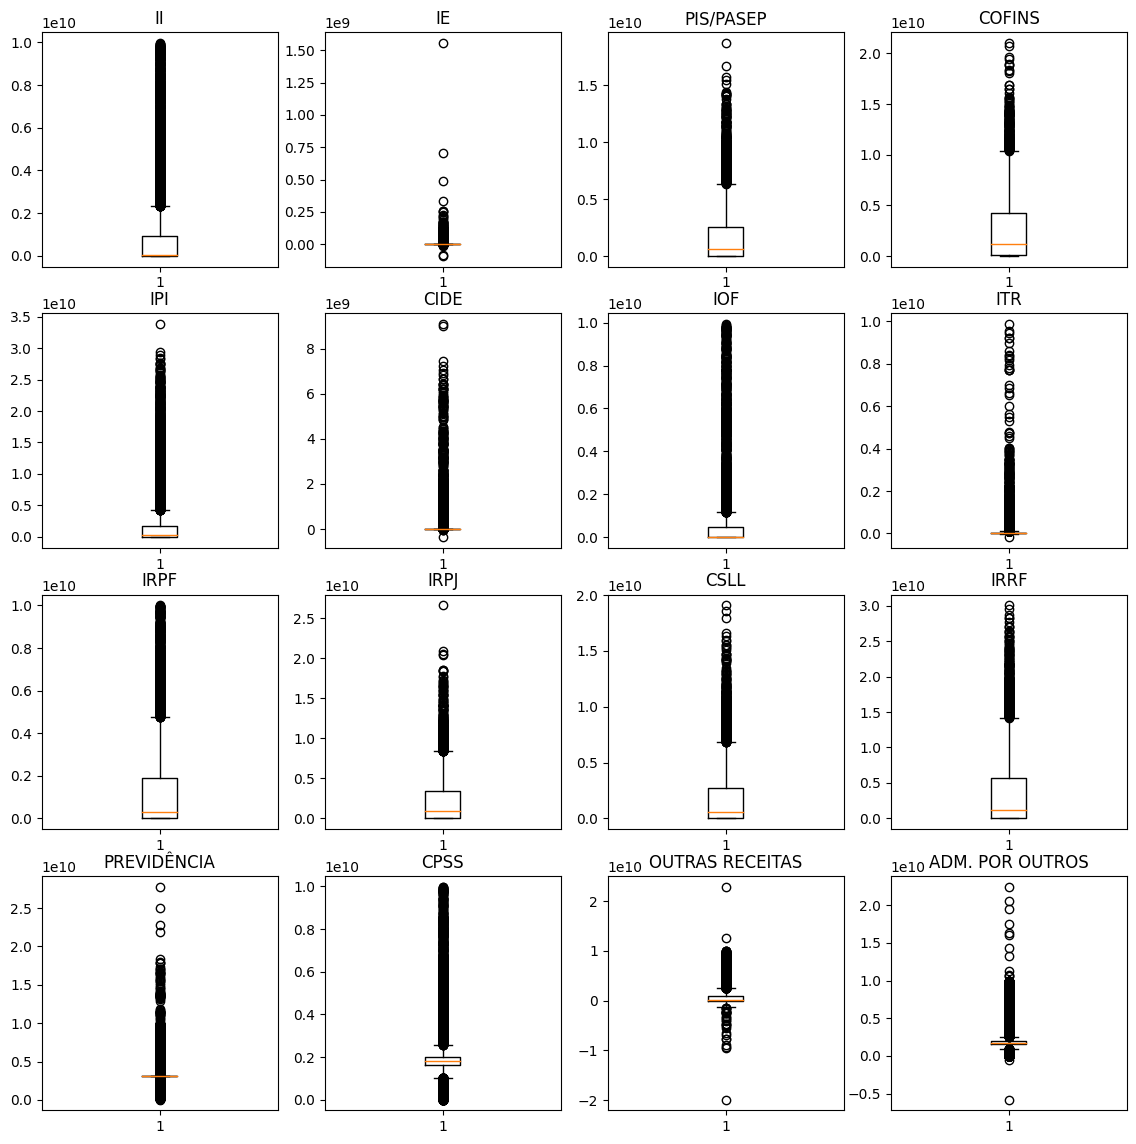

In [ ]:
#Analisando a distribuição dos valores por cada atributo do dataset

# configurando um grupo de subplots em um grid de 4 linhas e 4 colunas e também o tamanho da figura
fig, ax = plt.subplots(4,4, figsize = (14, 14)) 

# subplot1: boxplot do II
ax[0,0].boxplot(arrecadacao['IMPOSTO SOBRE IMPORTAÇÃO'])
ax[0,0].set_title("II")

# subplot2: boxplot do IE
ax[0,1].boxplot(arrecadacao['IMPOSTO SOBRE EXPORTAÇÃO'])
ax[0,1].set_title("IE")

# subplot3: boxplot do PIS/PASEP
ax[0,2].boxplot(arrecadacao['CONTRIBUIÇÃO PARA O PIS/PASEP'])
ax[0,2].set_title("PIS/PASEP")

# subplot4: boxplot do COFINS
ax[0,3].boxplot(arrecadacao['COFINS'])
ax[0,3].set_title("COFINS")

# subplot5: boxplot do IPI
ax[1,0].boxplot(arrecadacao['IPI'])
ax[1,0].set_title("IPI")

# subplot6: boxplot do CIDE
ax[1,1].boxplot(arrecadacao['CIDE-COMBUSTÍVEIS'])
ax[1,1].set_title("CIDE")

# subplot7: boxplot dos IOF
ax[1,2].boxplot(arrecadacao['IMPOSTO S/ OPERAÇÕES FINANCEIRAS'])
ax[1,2].set_title("IOF")

# subplot8: boxplot dos ITR
ax[1,3].boxplot(arrecadacao['IMPOSTO TERRITORIAL RURAL'])
ax[1,3].set_title("ITR")

# subplot9: boxplot do IRPF
ax[2,0].boxplot(arrecadacao['IRPF'])
ax[2,0].set_title("IRPF")

# subplot10: boxplot do IRPJ
ax[2,1].boxplot(arrecadacao['IRPJ'])
ax[2,1].set_title("IRPJ")

# subplot11: boxplot dos CSLL
ax[2,2].boxplot(arrecadacao['CSLL'])
ax[2,2].set_title("CSLL")

# subplot12: boxplot dos IRRF
ax[2,3].boxplot(arrecadacao['IRRF'])
ax[2,3].set_title("IRRF")

# subplot13: boxplot do RECEITA PREVIDENCIÁRIA
ax[3,0].boxplot(arrecadacao['RECEITA PREVIDENCIÁRIA'])
ax[3,0].set_title("PREVIDÊNCIA")

# subplot14: boxplot do CPSSS
ax[3,1].boxplot(arrecadacao['CPSSS - Contrib. p/ o Plano de Segurid. Social Serv. Público'])
ax[3,1].set_title("CPSS")

# subplot15: boxplot dos OUTRAS RECEITAS ADMINISTRADAS
ax[3,2].boxplot(arrecadacao['OUTRAS RECEITAS ADMINISTRADAS'])
ax[3,2].set_title("OUTRAS RECEITAS")

# subplot16: boxplot dos ADMINISTRADAS POR OUTROS ÓRGÃOS
ax[3,3].boxplot(arrecadacao['ADMINISTRADAS POR OUTROS ÓRGÃOS'])
ax[3,3].set_title("ADM. POR OUTROS")

#Foram testados diferentes visões do dataframe, porém a distribuição manteve-se com comportamento atípico. Seria necessário mais avaliações para compreender o comportamento da distribuição.

Text(0, 0.5, 'CSLL')

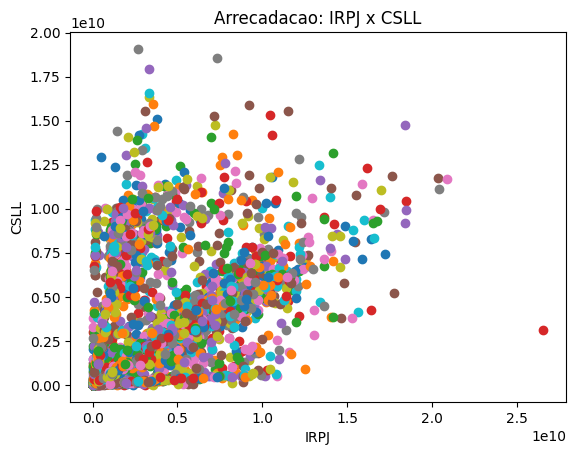

In [ ]:
#A análise dos gráficos de scatter apresentam desempenho lento e há poucos casos em que a relação entre os tributos se faça necessária.

#O gráfico demonstra a relação entre o IRPJ e a CSLL, dois tributos incidentes sobre a renda das Pessoas Jurídicas.
for i in range(len(arrecadacao['UF'])):
    plt.scatter(arrecadacao['IRPJ'][i], arrecadacao['CSLL'][i])

# incluindo título do gráfico e rótulos dos eixos
plt.title('Arrecadacao: IRPJ x CSLL')
plt.xlabel('IRPJ')
plt.ylabel('CSLL')

#O resultado demonstra uma relação aparentemente equilibrada, algo previsível, dado que os dois tributos tem base de cálculo e alíquotas semelhantes.

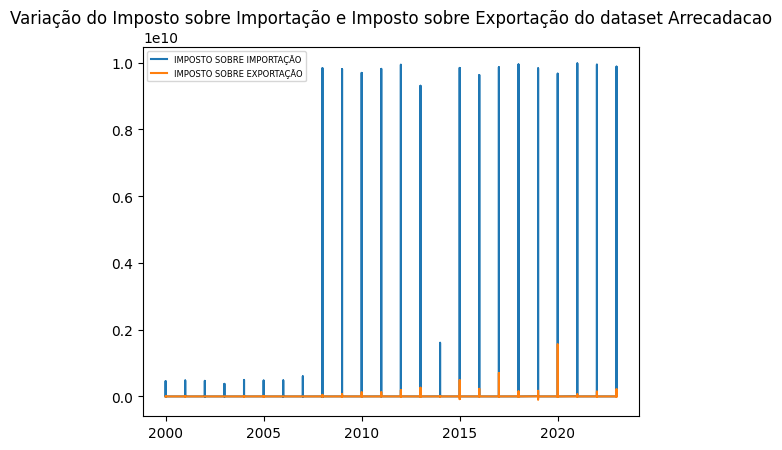

In [ ]:
# Gráfico de Linhas usado para verificar a distribuição do Imposto sobe Importação e Exportação por ano

# selecionando apenas os atributos para serem plotados
atributos = ['IMPOSTO SOBRE IMPORTAÇÃO', 'IMPOSTO SOBRE EXPORTAÇÃO']

# criando o eixo x - vai de do ano 2000 até 2023
x_data = arrecadacao['Ano']#range(0, arrecadacao.shape[0])

# plotando cada atributo
for atributo in atributos: 
    plt.plot(x_data, arrecadacao[atributo], label=atributo)
    
# incluindo título do gráfico e legenda
plt.title('Variação do Imposto sobre Importação e Imposto sobre Exportação do dataset Arrecadacao')
plt.legend(fontsize=6, loc='best')
#Identifica-se que a discrepância entre os dois impostos é coerente, dado o governo estabelece política de incentivos as exportações, reduzindo a tributação sobre essas operações.

C:\Users\us6x\AppData\Local\Temp\ipykernel_15040\1173166149.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(arrecadacao.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)


<AxesSubplot: >

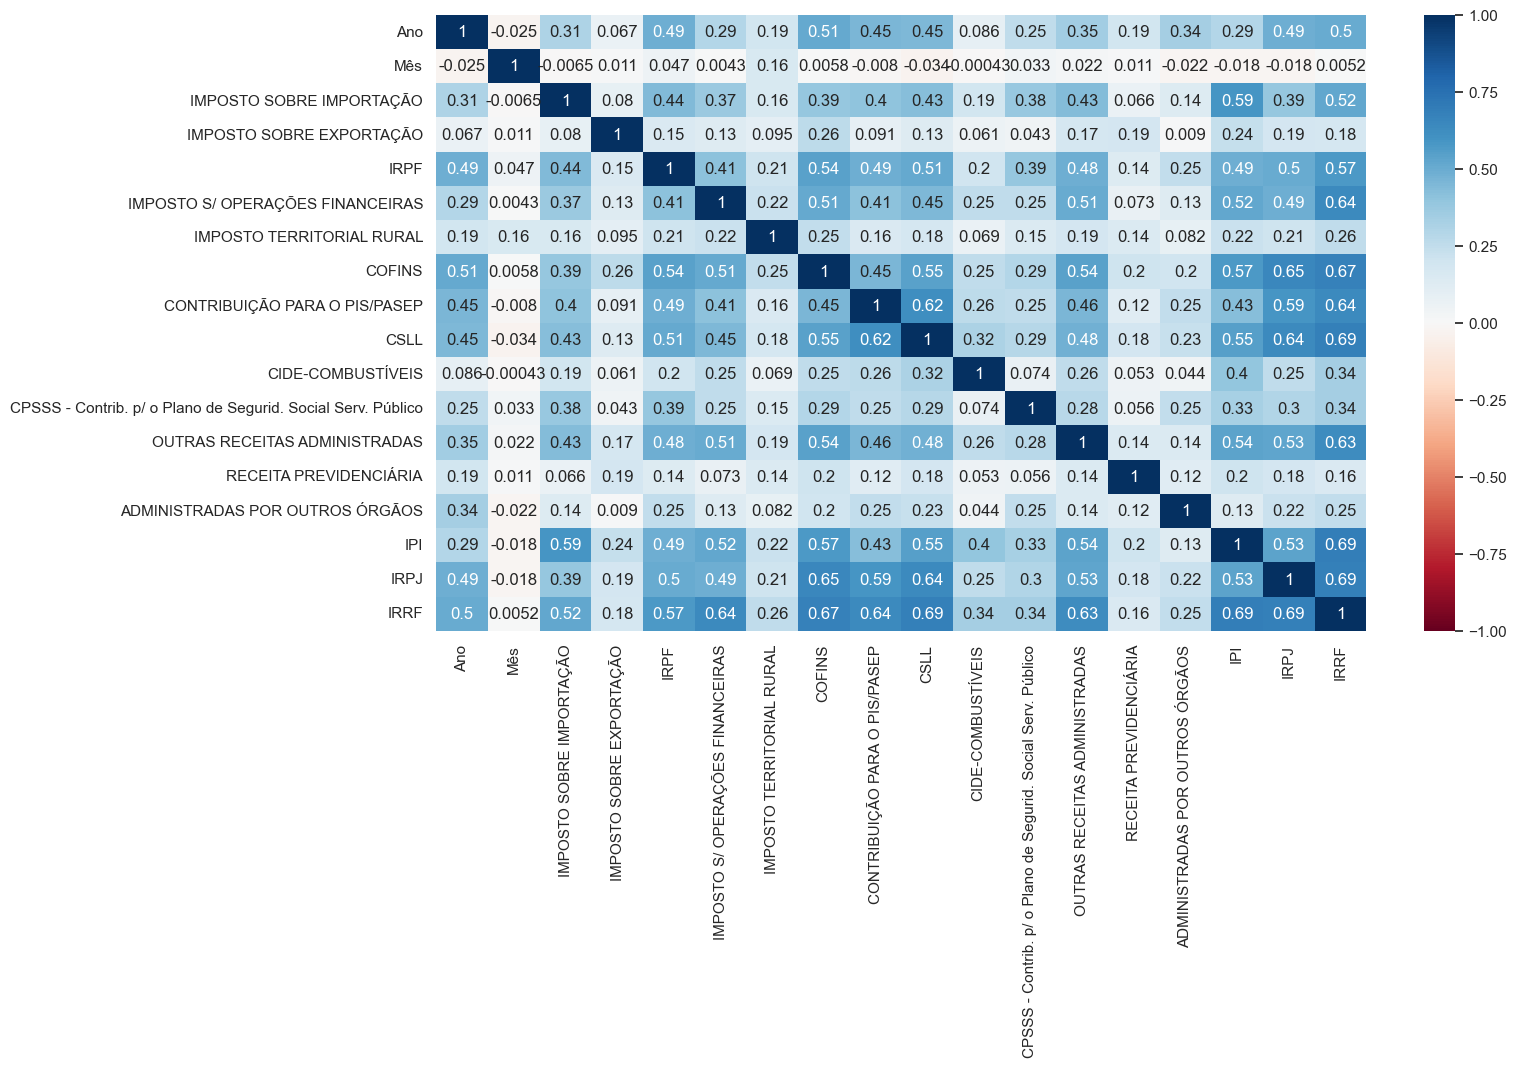

In [ ]:
#Avaliando a relação entre os tributos
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(arrecadacao.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)

#A distribuição aponta que o IRRF apresenta uma quantidade maior de relações mais altas. Além disso, não há relações negativas.

Segundo pré-processamento

In [1611]:
arrecadacao

,Ano,Mês,UF,IMPOSTO SOBRE IMPORTAÇÃO,IMPOSTO SOBRE EXPORTAÇÃO,IPI - FUMO,IPI - BEBIDAS,IPI - AUTOMÓVEIS,IPI - VINCULADO À IMPORTACAO,IPI - OUTROS,...,PAES,RETENÇÃO NA FONTE - LEI 10.833 Art. 30,PAGAMENTO UNIFICADO,OUTRAS RECEITAS ADMINISTRADAS,DEMAIS RECEITAS,RECEITA PREVIDENCIÁRIA,RECEITA PREVIDENCIÁRIA - PRÓPRIA,RECEITA PREVIDENCIÁRIA - DEMAIS,ADMINISTRADAS POR OUTROS ÓRGÃOS,DATA
0,2000,1,AC,231,0,292096,0,0,167,1558,...,NaN,NaN,NaN,20911,NaN,3.114104e+09,NaN,NaN,1.765880e+09,2000-01-01
1,2000,1,AL,475088,33873,1329338,812470,0,141735,3676847,...,NaN,NaN,NaN,127189,NaN,3.114104e+09,NaN,NaN,1.765880e+09,2000-01-01
2,2000,1,AM,11679405,0,1507146,1791471,27796,4414483,1800346,...,NaN,NaN,NaN,187988,NaN,3.114104e+09,NaN,NaN,1.765880e+09,2000-01-01
3,2000,1,AP,24267,0,424862,1419,321,22333,12165,...,NaN,NaN,NaN,10769,NaN,3.114104e+09,NaN,NaN,1.765880e+09,2000-01-01
4,2000,1,BA,10476457,13,5542123,11533707,0,7496476,23743858,...,NaN,NaN,NaN,536498,NaN,3.114104e+09,NaN,NaN,1.765880e+09,2000-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7528,2023,Março,RS,15836217,0,0,0,0,2420866,23524606,...,NaN,NaN,NaN,56294066,NaN,6.874600e+09,NaN,NaN,1.065146e+09,7528
7529,2023,Março,SC,1002120548,858532,0,897532412,3011745881,3881102956,3720682797,...,NaN,NaN,NaN,8971306055,NaN,2.420498e+09,NaN,NaN,2.907057e+09,7529
7530,2023,Março,SE,1792437623,-1309421,231803776,451808802,1839273499,6451088764,1033460741,...,NaN,NaN,NaN,1480417865,NaN,1.779441e+10,NaN,NaN,2.574332e+08,7530
7531,2023,Março,SP,379440024,214698413,37450835,203994968,0,11139877,657689162,...,NaN,NaN,NaN,380583903,NaN,2.347739e+09,NaN,NaN,3.542186e+09,7531


In [1612]:
# Separando os valores do dataset em componentes de input (X) e output (Y)
amostra = arrecadacao
x = amostra.values[:, 4:17]
y = amostra.values[:, 17]

#Normalizando a distribuição dado que há valores negativos que tem afetado as análises
rescaled_x = MinMaxScaler().fit_transform(x)

# Exibindo os dados transformados
print("Dados Originais: \n\n", amostra.values)
print("\nDados Normalizados (não inclui a coluna class): \n\n", rescaled_x)

Dados Originais: 

 [[2000 1 'AC' ... nan 1765880363.0 datetime.date(2000, 1, 1)]
 [2000 1 'AL' ... nan 1765880363.0 datetime.date(2000, 1, 1)]
 [2000 1 'AM' ... nan 1765880363.0 datetime.date(2000, 1, 1)]
 ...
 [2023 'Março' 'SE' ... nan 257433219.0 7530]
 [2023 'Março' 'SP' ... nan 3542186066.0 7531]
 [2023 'Março' 'TO' ... nan 2955794943.0 7532]]

Dados Normalizados (não inclui a coluna class): 

 [[0.05553189 0.04190599 0.00108447 ... 0.14504148 0.20592768 0.00142322]
 [0.05555243 0.04200632 0.00116608 ... 0.14508149 0.20594285 0.00145111]
 [0.05553189 0.04202352 0.00126441 ... 0.14513554 0.20621222 0.00152313]
 ...
 [0.05473771 0.06430092 0.04646404 ... 0.45326856 0.44889764 0.71276604]
 [0.18574881 0.04550048 0.02157368 ... 0.14799433 0.21820628 0.00443803]
 [0.05553189 0.04187773 0.00433182 ... 0.1504121  0.21955181 0.01495177]]


In [1613]:
# Padronizando os dados
standared_x = StandardScaler().fit_transform(x)

# Exibindo os dados transformados
print("Dados Originais: \n\n", amostra.values)
print("\nDados Padronizados (não inclui a coluna class): \n\n", standared_x)

Dados Originais: 

 [[2000 1 'AC' ... nan 1765880363.0 datetime.date(2000, 1, 1)]
 [2000 1 'AL' ... nan 1765880363.0 datetime.date(2000, 1, 1)]
 [2000 1 'AM' ... nan 1765880363.0 datetime.date(2000, 1, 1)]
 ...
 [2023 'Março' 'SE' ... nan 257433219.0 7530]
 [2023 'Março' 'SP' ... nan 3542186066.0 7531]
 [2023 'Março' 'TO' ... nan 2955794943.0 7532]]

Dados Padronizados (não inclui a coluna class): 

 [[-0.12593775 -0.20691218 -0.400451   ... -0.46692685 -0.42851634
  -0.43595124]
 [-0.12460578 -0.20566096 -0.39966898 ... -0.46662687 -0.42838778
  -0.43574936]
 [-0.12593775 -0.20544647 -0.39872668 ... -0.4662216  -0.42610478
  -0.43522807]
 ...
 [-0.17742744  0.07235855  0.03442087 ...  1.84421895  1.63066915
   4.71327185]
 [ 8.31653714 -0.16208788 -0.20410318 ... -0.44478584 -0.32445438
  -0.41412781]
 [-0.12593775 -0.20726453 -0.3693317  ... -0.42665692 -0.31305095
  -0.33802167]]


In [1616]:
# ordinal encoding para os atributos x
ordered_x = OrdinalEncoder().fit_transform(x)

# exibindo os dados transformados
print("Atributos transformados:")
print(ordered_x)
     

Atributos transformados:
[[1.227e+03 5.810e+02 3.000e+00 ... 1.830e+02 8.900e+01 6.800e+01]
 [2.783e+03 1.630e+03 7.490e+02 ... 1.034e+03 1.178e+03 6.800e+02]
 [1.227e+03 1.728e+03 1.125e+03 ... 1.426e+03 2.542e+03 1.306e+03]
 ...
 [1.000e+01 4.133e+03 5.291e+03 ... 7.037e+03 6.788e+03 7.425e+03]
 [5.707e+03 3.603e+03 4.616e+03 ... 3.291e+03 4.902e+03 3.293e+03]
 [1.227e+03 6.000e+00 3.512e+03 ... 3.721e+03 4.955e+03 4.430e+03]]


In [1614]:
# one hot encode para os atributos x
encoded_x = OneHotEncoder(sparse=False).fit_transform(x)

# exibindo os dados transformados
print("Atributos transformados:")
print(encoded_x)

c:\Users\us6x\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Atributos transformados:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
